<a href="https://colab.research.google.com/github/jordan-dsouza/Projects/blob/main/Hospital_Cost_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import OrdinalEncoder
import plotly.express as px
from statsmodels.formula.api import ols
import statsmodels.api  as sm
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

#**Data Cleaning:**

In [ ]:
address = ""
hosp = pd.read_csv(address + "Hospitalisation details.csv")
medic = pd.read_csv(address + "Medical Examinations.csv")
names = pd.read_excel(address + "Names.xlsx")

In [ ]:
hosp.head()

,Customer ID,year,month,date,children,charges,Hospital tier,City tier,State ID
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013
2,Id2333,1993,Jun,30,0,600.00,tier - 2,tier - 1,R1013
3,Id2332,1992,Sep,13,0,604.54,tier - 3,tier - 3,R1013
4,Id2331,1998,Jul,27,0,637.26,tier - 3,tier - 3,R1013


In [ ]:
master_data = pd.merge(hosp, medic, how = "inner", on = "Customer ID")
master_data = master_data.merge(names, on="Customer ID")

In [ ]:
master_data.columns = master_data.columns.str.lower()
master_data.columns = master_data.columns.str.replace(' ','_')
master_data.columns

Index(['customer_id', 'year', 'month', 'date', 'children', 'charges',
       'hospital_tier', 'city_tier', 'state_id', 'bmi', 'hba1c',
       'heart_issues', 'any_transplants', 'cancer_history',
       'numberofmajorsurgeries', 'smoker', 'name'],
      dtype='object')

In [ ]:
(master_data == '?').sum()

customer_id               0
year                      2
month                     3
date                      0
children                  0
charges                   0
hospital_tier             1
city_tier                 1
state_id                  2
bmi                       0
hba1c                     0
heart_issues              0
any_transplants           0
cancer_history            0
numberofmajorsurgeries    0
smoker                    2
name                      0
dtype: int64

In [ ]:
miss_perc = (master_data == '?').sum(axis = 1)/master_data.shape[1] * 100
miss_perc[miss_perc > 0].index

Index([11, 13, 17, 542, 1046, 1049, 1700, 1775, 2165, 2332], dtype='int64')

In [ ]:
#Drop missing values:
master_noq = master_data.drop(index = miss_perc[miss_perc>0].index)
master_noq.shape

(2325, 17)

In [ ]:
master_noq.isna().sum()

customer_id               0
year                      0
month                     0
date                      0
children                  0
charges                   0
hospital_tier             0
city_tier                 0
state_id                  0
bmi                       0
hba1c                     0
heart_issues              0
any_transplants           0
cancer_history            0
numberofmajorsurgeries    0
smoker                    0
name                      0
dtype: int64

##Ordinal Nominal:

In [ ]:
# Using ordinalencoder to deal with ordinal categorical variables - city tier and hospital tier:
ordinal = OrdinalEncoder(categories= [['tier - 3', 'tier - 2', 'tier - 1'],['tier - 3', 'tier - 2', 'tier - 1']])
master_noq[['city_tier_ord','hospital_tier_ord']] = ordinal.fit_transform(master_noq[['city_tier', 'hospital_tier']])

In [ ]:
pd.crosstab(master_noq['city_tier_ord'],master_noq['city_tier'])

city_tier,tier - 1,tier - 2,tier - 3
city_tier_ord,,,
0.0,0,0,789
1.0,0,807,0
2.0,729,0,0


In [ ]:
pd.crosstab(master_noq['hospital_tier_ord'],master_noq['hospital_tier'])

hospital_tier,tier - 1,tier - 2,tier - 3
hospital_tier_ord,,,
0.0,0,0,691
1.0,0,1334,0
2.0,300,0,0


In [ ]:
master_noq.head(2)

,customer_id,year,month,date,children,charges,hospital_tier,city_tier,state_id,bmi,hba1c,heart_issues,any_transplants,cancer_history,numberofmajorsurgeries,smoker,name,city_tier_ord,hospital_tier_ord
0,Id2335,1992,Jul,9,0,563.84,tier - 2,tier - 3,R1013,17.58,4.51,No,No,No,1,No,"German, Mr. Aaron K",0.0,1.0
1,Id2334,1992,Nov,30,0,570.62,tier - 2,tier - 1,R1013,17.60,4.39,No,No,No,1,No,"Rosendahl, Mr. Evan P",2.0,1.0


In [ ]:
vc = master_noq.state_id.value_counts()   # Freq of each category
vc[:3].index                              # Top 3 most frequent categories

Index(['R1013', 'R1011', 'R1012'], dtype='object', name='state_id')

In [ ]:
for i in vc[:3].index:
    var_name = 'state_id_' +i   # create name for the dummy varible
    print(var_name)
    master_noq[var_name] = 0    # giving a dummy value 0 to dummy variable
    master_noq.loc[master_noq.state_id == i,var_name] = 1  # replacing 0 by 1 where state id is equal to category of the dummy variable


state_id_R1013
state_id_R1011
state_id_R1012


##No of Maj Surgery:

In [ ]:
master_noq.numberofmajorsurgeries.unique()

array(['1', 'No major surgery', '2', '3'], dtype=object)

In [ ]:
master_noq.loc[master_noq.numberofmajorsurgeries == 'No major surgery','numberofmajorsurgeries' ] = 0

In [ ]:
master_noq.numberofmajorsurgeries = master_noq.numberofmajorsurgeries.astype(int)

##Age:

In [ ]:
master_noq.year = master_noq.year.astype(int)
master_noq['age'] = 2023 - master_noq.year

##Gender:

In [ ]:
master_noq['title'] = master_noq.name.str.split('[,.]').str[1].str.strip()

In [ ]:
master_noq['gender'] = 'female'
master_noq.loc[master_noq.title == 'Mr', 'gender'] = 'male'

In [ ]:
master_noq['gender'].value_counts()

gender
female    1165
male      1160
Name: count, dtype: int64

#**Data Visualization:**

##Charges distribution:

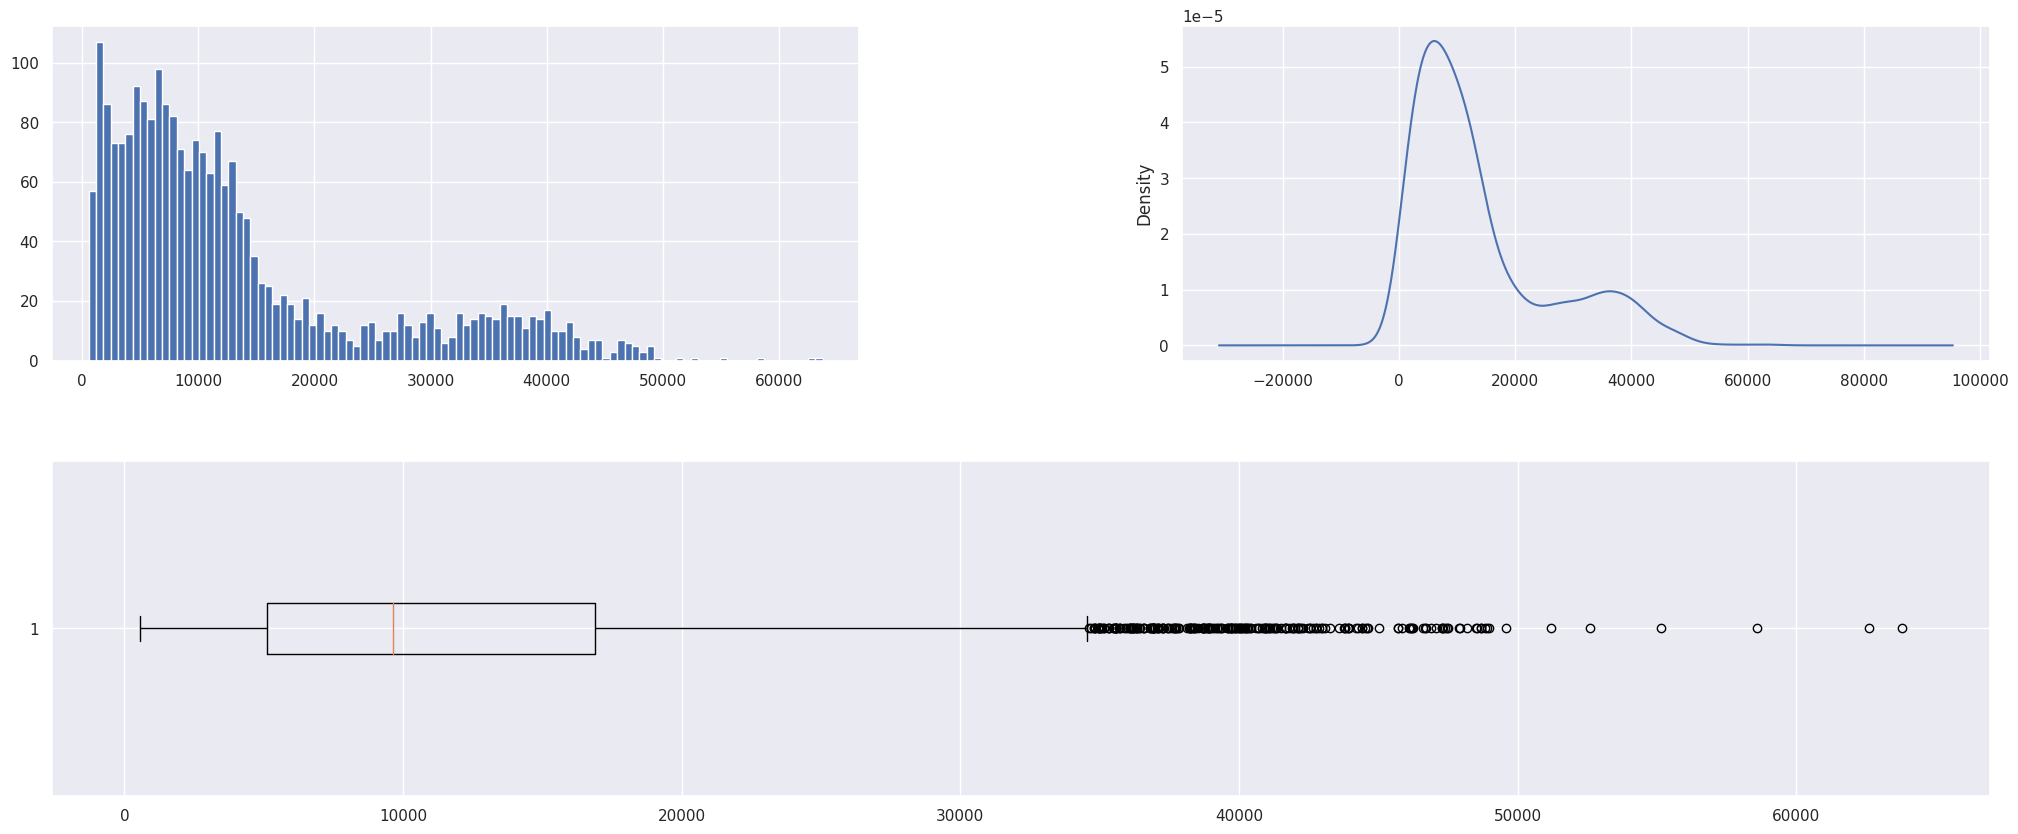

In [ ]:
#Cost distribution (Charges):
#Histogram, KDE, Boxplot with outliers:
plt.figure(figsize = (25,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
plt.subplot(grid[0, 0])
plt.hist(master_noq.charges, bins = 100)
plt.subplot(grid[0, 1])
master_noq.charges.plot.kde()
plt.subplot(grid[1, :])
plt.boxplot(master_noq.charges, vert = False)
plt.show()

#Charges wrt Gender:

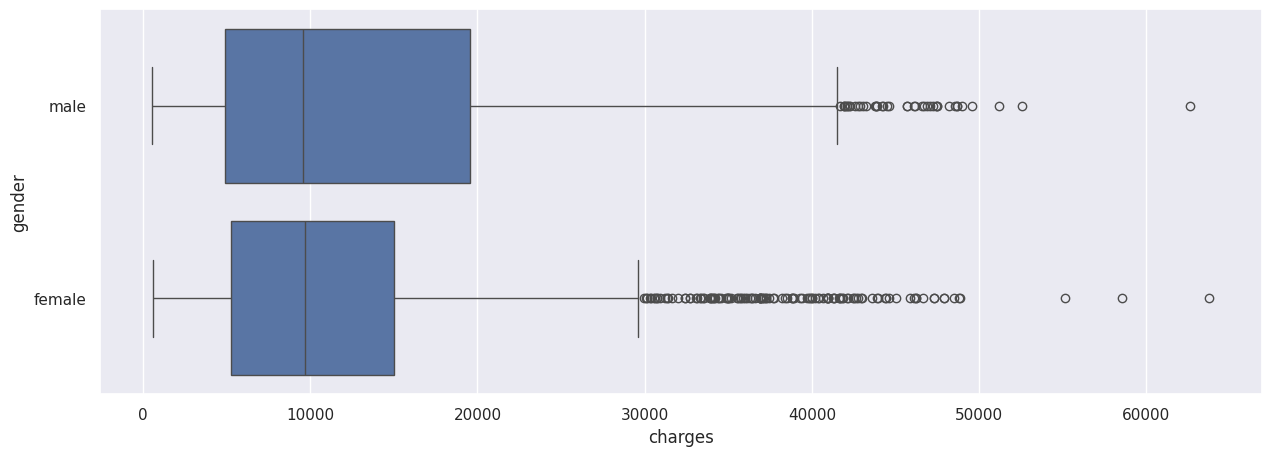

In [ ]:
plt.figure(figsize = (15,5))
sns.boxplot(x = "charges",y = "gender", data = master_noq)
plt.show()

##Charges wrt city:

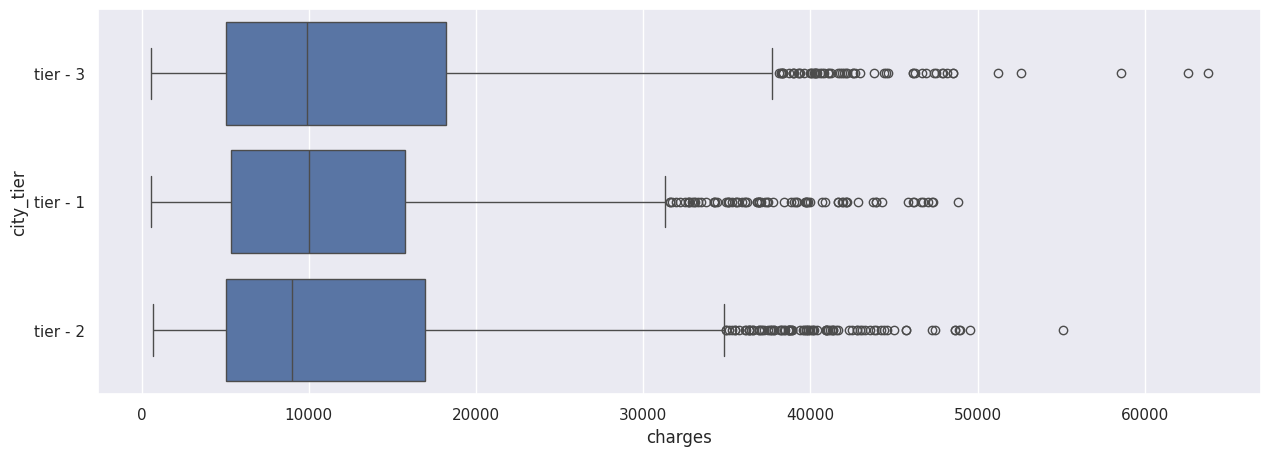

In [ ]:
plt.figure(figsize = (15,5))
sns.boxplot(x = "charges",y = "city_tier", data = master_noq)
plt.show()

##Charges wrt Hospital Charges:

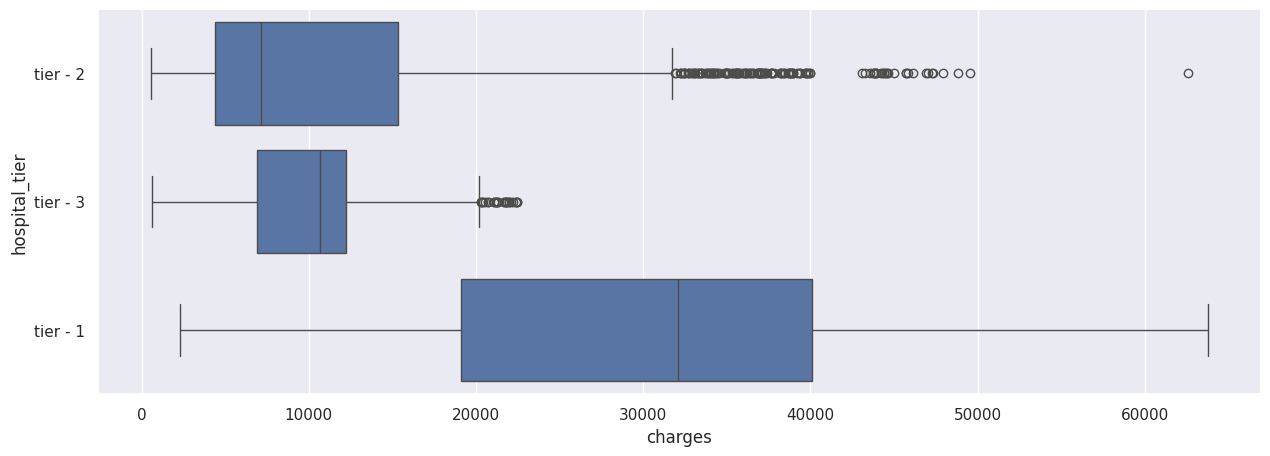

In [ ]:
plt.figure(figsize = (15,5))
sns.boxplot(x = "charges",y = "hospital_tier", data = master_noq)
plt.show()

##Charges vs hospital tier Radar

In [ ]:
median = master_noq.groupby('hospital_tier')[['charges']].median().reset_index()

In [ ]:
fig = px.line_polar(median, r='charges', theta='hospital_tier') #, line_close=True
fig.show()

##Crosstab frequency tables:

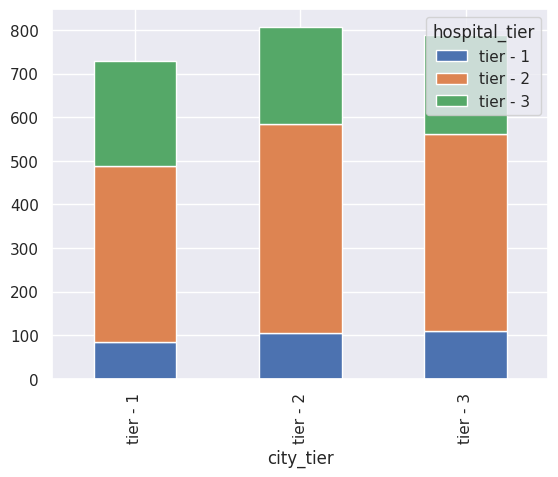

In [ ]:
pd.crosstab(master_noq.city_tier, master_noq.hospital_tier).plot.bar(stacked = True)
plt.show()

#**Null Hypothesis:**

####H0 : Average hospitalization cost across the 3 types of hospitals is not significantly different

In [ ]:
mod = ols('charges ~ hospital_tier', data = master_noq).fit()
res = sm.stats.anova_lm(mod)
res

,df,sum_sq,mean_sq,F,PR(>F)
hospital_tier,2.0,9.763011e+10,4.881505e+10,493.989566,1.773822e-179
Residual,2322.0,2.294554e+11,9.881799e+07,NaN,NaN


#### H0 = Average hospitalization cost across the 3 types of cities is not significantly different

In [ ]:
mod = ols('charges ~ city_tier', data = master_noq).fit()
res = sm.stats.anova_lm(mod)
res

,df,sum_sq,mean_sq,F,PR(>F)
city_tier,2.0,4.092192e+08,2.046096e+08,1.454356,0.233763
Residual,2322.0,3.266763e+11,1.406874e+08,NaN,NaN


#### H0: Average hospitalization cost for smokers is not significantly different than non-smokers

In [ ]:
sample1 = master_noq.loc[master_noq.smoker == 'yes', 'charges']
sample2 = master_noq.loc[master_noq.smoker != 'yes', 'charges']
stats.ttest_ind(sample1, sample2)

TtestResult(statistic=74.15560699695726, pvalue=0.0, df=2323.0)

#### H0 : Smoking and Heart issues are independent4

In [ ]:
observed_table = pd.crosstab(master_noq.smoker, master_data.heart_issues)
observed_table

heart_issues,No,yes
smoker,,
No,1108,731
yes,297,189


In [ ]:
chi, p, df, expected = stats.chi2_contingency(observed_table)
chi, p, df, expected

(0.08588150449910657,
 0.7694797581780767,
 1,
 array([[1111.30967742,  727.69032258],
        [ 293.69032258,  192.30967742]]))

#**Correlation:**

In [ ]:
data = master_noq.drop(columns = ['customer_id','name', 'year', 'month', 'date','hospital_tier',
       'city_tier', 'state_id' , 'title'])

In [ ]:
corr_plot = data.select_dtypes(exclude='object').corr()
ma = np.ones_like(corr_plot)
ma[np.tril_indices_from(ma)] = 0

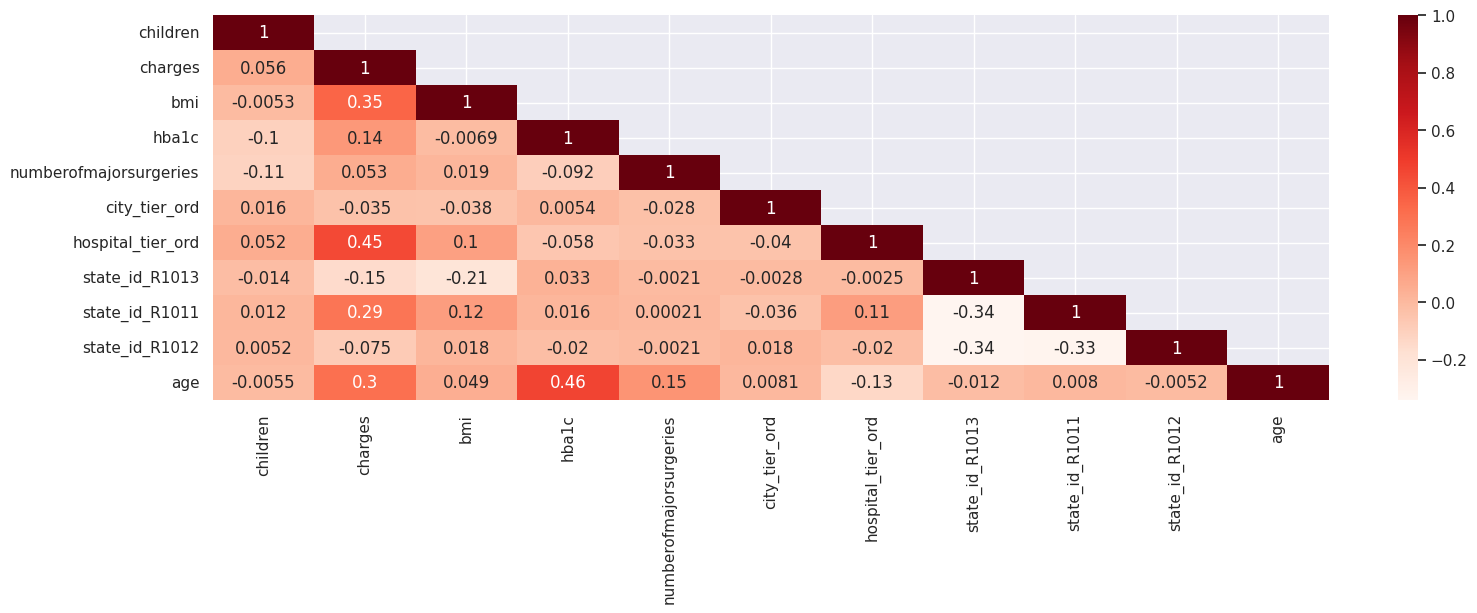

In [ ]:
plt.figure(figsize = (18,5))
sns.heatmap(corr_plot, annot= True , mask = ma, cmap='Reds')
plt.show()

#**Model:**

In [ ]:
df = pd.get_dummies(data, drop_first=True)
df.reset_index(drop=True, inplace = True)
df.head()

,children,charges,bmi,hba1c,numberofmajorsurgeries,city_tier_ord,hospital_tier_ord,state_id_R1013,state_id_R1011,state_id_R1012,age,heart_issues_yes,any_transplants_yes,cancer_history_Yes,smoker_yes,gender_male
0,0,563.84,17.58,4.51,1,0.0,1.0,1,0,0,31,False,False,False,False,True
1,0,570.62,17.60,4.39,1,2.0,1.0,1,0,0,31,False,False,False,False,True
2,0,600.00,16.47,6.35,1,2.0,1.0,1,0,0,30,False,False,True,False,False
3,0,604.54,17.70,6.28,1,0.0,0.0,1,0,0,31,False,False,False,False,True
4,0,637.26,22.34,5.57,1,0.0,0.0,1,0,0,25,False,False,False,False,True


In [ ]:
# rearrange data to put 'charges' as first column or last
model_data = df.drop(columns = 'charges')
model_data.head()
model_data['charges'] = df.charges
model_data.head()

,children,bmi,hba1c,numberofmajorsurgeries,city_tier_ord,hospital_tier_ord,state_id_R1013,state_id_R1011,state_id_R1012,age,heart_issues_yes,any_transplants_yes,cancer_history_Yes,smoker_yes,gender_male,charges
0,0,17.58,4.51,1,0.0,1.0,1,0,0,31,False,False,False,False,True,563.84
1,0,17.60,4.39,1,2.0,1.0,1,0,0,31,False,False,False,False,True,570.62
2,0,16.47,6.35,1,2.0,1.0,1,0,0,30,False,False,True,False,False,600.00
3,0,17.70,6.28,1,0.0,0.0,1,0,0,31,False,False,False,False,True,604.54
4,0,22.34,5.57,1,0.0,0.0,1,0,0,25,False,False,False,False,True,637.26


In [ ]:
#Stratified k fold:
y = model_data['charges']
X = model_data.drop(columns = 'charges')

In [ ]:
#Setting up a pipeline:
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge())])

In [ ]:
#Parameter definition for hyperparameter tuning:
parameters = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [ ]:
#KFold object:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
#GridSearch object:
model_ridge = GridSearchCV(pipeline, parameters, cv=kfold, scoring='neg_mean_squared_error')

In [ ]:
model_ridge.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
#Best parameters and model:
model_ridge.best_params_

{'regressor__alpha': 10}

In [ ]:
model_ridge.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge(alpha=10))])

#**Gradient Boost (XGBoost):**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
X_train,X_test,y_train,y_test = train_test_split(X,y)
#Train the XGBoost model:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)

[5.96119559e-03 1.17445862e-01 3.34328140e-03 2.97334456e-04
 2.91602910e-04 2.09651525e-02 4.21385567e-03 7.10727883e-03
 4.29037330e-04 1.02756833e-01 5.94852427e-05 9.32794717e-06
 3.39501641e-04 7.36091899e-01 6.88352426e-04]


##Features of importance:

In [ ]:
pd.DataFrame({'Features':model.feature_names_in_,'Importance':model.feature_importances_}).sort_values("Importance",ascending=False).T

,13,1,9,5,7,0,6,2,14,8,12,3,4,10,11
Features,smoker_yes,bmi,age,hospital_tier_ord,state_id_R1011,children,state_id_R1013,hba1c,gender_male,state_id_R1012,cancer_history_Yes,numberofmajorsurgeries,city_tier_ord,heart_issues_yes,any_transplants_yes
Importance,0.736092,0.117446,0.102757,0.020965,0.007107,0.005961,0.004214,0.003343,0.000688,0.000429,0.00034,0.000297,0.000292,0.000059,0.000009


In [ ]:
#Train score:
print("Train score:", model.score(X_train,y_train))
#Test score:
print("Test score:", model.score(X_test,y_test))

Train score: 0.9418695473696359
Test score: 0.8917456191392424


#**Prediction:**

In [ ]:
pred_df = pd.DataFrame({'Name' : ['Christopher, Ms. Jayna'],
                      'DOB' : ['12/28/1988'],
                      'city_tier' : ['tier - 1'], 'children' :[ 2],
                       'HbA1c' : [5.8],
                       'smoker_yes' : [1],
                       'heart_issues_yes' : [0],
                       'any_transplants_yes' : [0],
                       'numberofmajorsurgeries' :[ 0],
                       'cancer_history_yes' : [1],
                       'hospital_tier' : ['tier - 1'],
                       'bmi' : [85/(1.70 **2)],
                       'state_id_R1011' : [1]
                      })
pred_df

,Name,DOB,city_tier,children,HbA1c,smoker_yes,heart_issues_yes,any_transplants_yes,numberofmajorsurgeries,cancer_history_yes,hospital_tier,bmi,state_id_R1011
0,"Christopher, Ms. Jayna",12/28/1988,tier - 1,2,5.8,1,0,0,0,1,tier - 1,29.411765,1


In [ ]:
pred_df.columns = pred_df.columns.str.lower()

In [ ]:
pred_df['gender_male']  = 0
pred_df.loc[pred_df.name.str.split('[,.]').str[1] == 'Mr', 'gender_male'] = 1
pred_df.drop(columns = 'name', inplace = True)
pred_df

,dob,city_tier,children,hba1c,smoker_yes,heart_issues_yes,any_transplants_yes,numberofmajorsurgeries,cancer_history_yes,hospital_tier,bmi,state_id_r1011,gender_male
0,12/28/1988,tier - 1,2,5.8,1,0,0,0,1,tier - 1,29.411765,1,0


In [ ]:
pred_df.drop(columns = 'dob', inplace = True)

In [ ]:
pred_df[['city_tier_ord', 'hospital_tier_ord']] = ordinal.transform(pred_df[['city_tier', 'hospital_tier']])
pred_df.drop(columns =['city_tier', 'hospital_tier'], inplace = True )

In [ ]:
for col in model_data.columns:
    if col not in pred_df.columns and col != 'charges':
        pred_df[col] = 0

In [ ]:
pred_df=pred_df[model_data.drop(columns='charges').columns]

In [ ]:
model.predict(pred_df)

array([21571.55859884])